# This notebook contains the code to train SynthMorph with 3D sinograms
# Here a sanity check has been carried out to try to know if the model can be trained with just 10 data and a regularization term of 0 in the loss

## 1. Import of all the libraries and packages needed to run the code

In [1]:
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
import odl
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

2023-06-01 14:05:45.334885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 14:05:45.867601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-06-01 14:05:45.867621: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-01 14:05:48.100335: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7

## 2. Construction of the foreward projection operation : the ray transform

In [2]:
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[256, 256],
    dtype='float32')
angle_partition = odl.discr.partition.RectPartition(intv_prod=odl.set.domain.IntervalProd(0, 2 * np.pi), grid=odl.discr.grid.RectGrid(np.linspace(0,2*np.pi,360)))
# Detector: uniformly sampled, n = 512, min = -60, max = 60
detector_partition = odl.discr.partition.RectPartition(intv_prod=odl.set.domain.IntervalProd(-60, 60), grid=odl.discr.grid.RectGrid(np.linspace(-60, 60, 512)))
# Geometry with large fan angle
geometry = odl.tomo.geometry.conebeam.FanFlatGeometry(
    apart=angle_partition, dpart=detector_partition, src_radius=40, det_radius=40)
# Ray transform (= forward projection).
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

## 3. Creation of the 10 pairs of sinograms

In [3]:
# Input shapes.
in_shape = (256,) * 2 # Label maps dimensions. Warning : The shape must be consistent with the operator's shape!
num_dim = len(in_shape)
num_label = 16
num_maps = 10

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    warped_im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    # Creation of the "fixed" label map sinogram.
    sino_lab = ray_trafo(lab[:,:])
    # Creation of an image full of 0 with dimensions multiples of 16.
    sino_lab_bis = np.zeros((368, 512), dtype=np.uint8)
    # Insertion of the sinogram in the middle of the image.
    sino_lab_bis[4:4+sino_lab.shape[0], 0:0+sino_lab.shape[1]] = sino_lab
    label_maps.append(np.uint8(sino_lab_bis))
    warped_lab = tf.argmax(warped_im, axis=-1)
    # Creation of the "moving" label map sinogram.
    sino_warped_lab = ray_trafo(warped_lab[:,:])
    # Creation of an image full of 0 with dimensions multiples of 16.
    sino_warped_lab_bis = np.zeros((368, 512), dtype=np.uint8)
    # Insertion of the sinogram in the middle of the image.
    sino_warped_lab_bis[4:4+sino_warped_lab.shape[0], 0:0+sino_warped_lab.shape[1]] = sino_warped_lab
    label_maps.append(np.uint8(sino_warped_lab_bis))

  0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]2023-06-01 14:06:00.419153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-06-01 14:06:00.419452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mamo/devel/build/INSTALL/lib:/home/mamo/devel/build/INSTALL/lib64::
2023-06-01 14:06:00.419575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dyn

## 4. Creation of 20 grey-scale sinograms to train the model

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
1/1 [==============================] - 0s 87ms/step


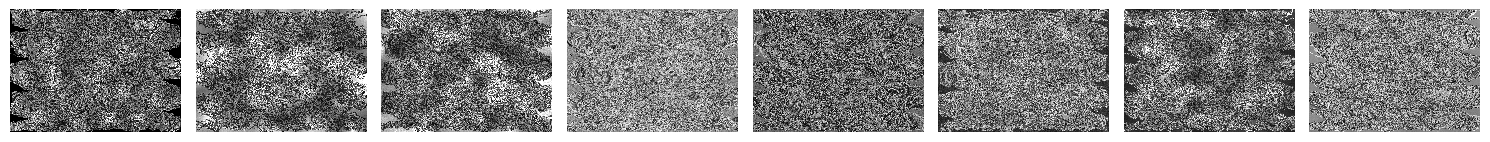

In [4]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape= (368, 512), # shape of the sinogram (must be a multiple of 16)
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)


# Test repeatedly for single input.
# We can see several sinogram contrasts from a given sinogram (here from the first "fixed" grey-scale sinogram).
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

## 5. Creation of the model

In [5]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape = (368, 512), # Shape of the sinogram (must be a multiple of 16).
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([512]*4, [368]*8),
    reg_field='warp',
)


# Define regularisation strength.
regularisation_strength = 0

# Get the regularisation losses from the VxmDense layer.
regularisation_loss = tf.reduce_sum(reg_model.losses)

# Define the custom loss function with regularisation.
def custom_loss(y_true, y_pred):
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss += regularisation_strength * regularisation_loss
    return loss

reg_model.compile(loss=custom_loss)

# Model for optimisation.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)
# The inputs in a Keras model are used to define the placeholders or containers for the input data that will 
# be fed into the model during training or inference. 
# They represent the expected shape and type of the input data.
    
# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


## 6. Train SynthMorph over few epochs

In [ ]:
# Train model for a few epochs. 
# Re-running the cell will continue training.

gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1, # Number of samples per gradient update.
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=105,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)

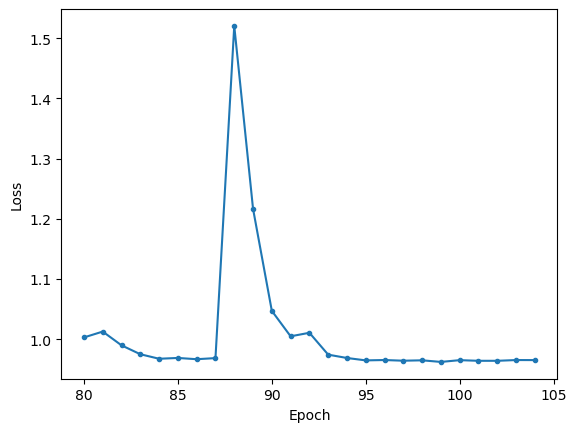

In [10]:
# Visualise loss.
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');